# Detecting things

In astrophysics the question of detection is generaly strongly connected to the question of SNR. We will thus start to give a definition of the SNR.

In [1]:
import numpy as np
import pylab as pl
import scipy.optimize

## Signal-to-noise ratio (SNR)

<div>
<img src="../images/acoustic_locator_3.jpg" width="500"/>
</div>

https://rarehistoricalphotos.com/aircraft-detection-radar-1917-1940/ (have a look it's fun)

SNR definition comes mainly from the electricity/engineering field. From https://en.wikipedia.org/wiki/Signal-to-noise_ratio, we can read that

`SNR = P(signal) / P(noise)`, this is a **ratio of two power measures** (i.e., energy/s, i.e. photon flux in our case). It is **important** to keep in mind that it is not the ratio of two amplitudes for example.


## cosine signal, e.g. planetary orbit

SNR = 2.828253118822982 of each independant measures


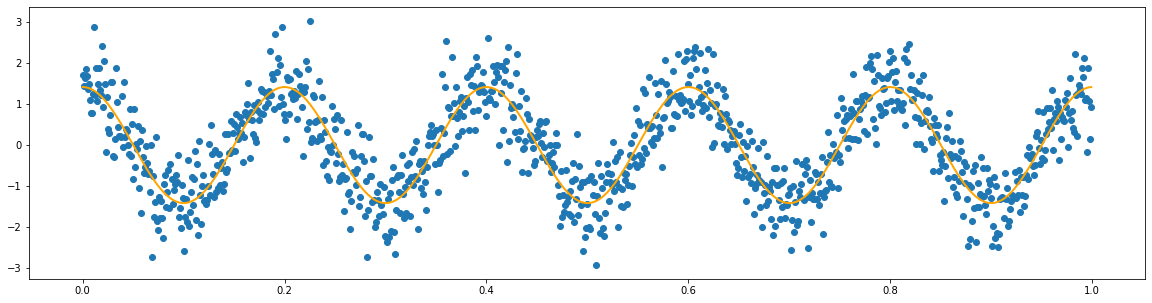

In [2]:
SNR = 3
time = np.arange(1000, dtype=float) / 1000  # 1 s
freq = 5 # Hz
signal = np.cos(time * freq * 2 * np.pi) * np.sqrt(2) # power of 1
noise = np.random.standard_normal(size=time.size) / np.sqrt(SNR)
pl.figure(figsize=(20,5))
pl.plot(time, signal, color='orange', lw=2)
pl.scatter(time, signal + noise)
signal_power = np.mean(signal**2) # note that the snr is the ratio of the **powers**
noise_power = np.mean(noise**2)
print('SNR =', signal_power/noise_power, 'of each independant measures')

But what if the signal (what we are interested in) is 0, what would be the SNR of such a measurment ?

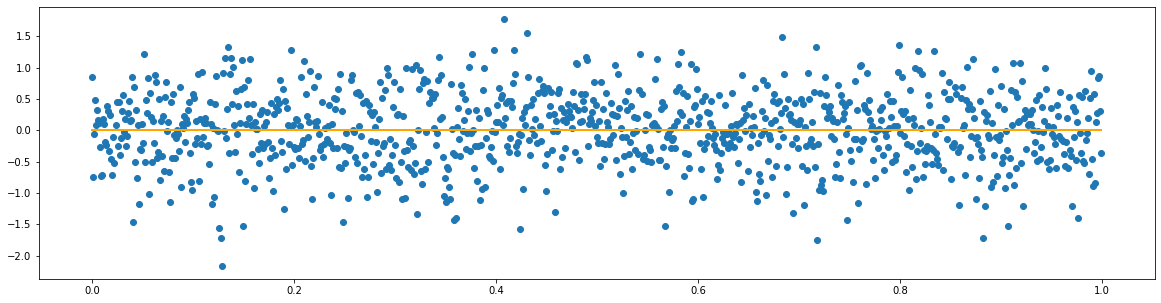

In [3]:
time = np.arange(1000, dtype=float) / 1000  # 1 s
signal = time * 0
noise = np.random.standard_normal(size=time.size) / np.sqrt(SNR)
pl.figure(figsize=(20,5))
pl.plot(time, signal, color='orange', lw=2)
pl.scatter(time, signal + noise)

## flux signal (as e.g. CCD counts)

### dispersive spectrum

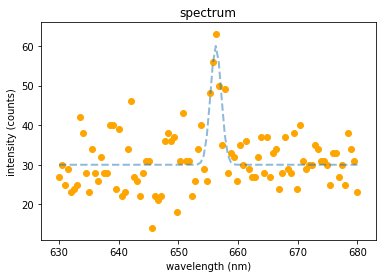

In [4]:
def gaussian_emission_line(x, a, dx, fwhm):
    width = fwhm / (2 * np.sqrt(2 * np.log(2))) # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
    return a * np.exp(-(x-dx)**2/width**2)

def simulate_el(background, amplitude, fwhm, plot=True, title='spectrum'):
    lam = np.linspace(630, 680, 100)
    spectrum = gaussian_emission_line(lam, amplitude, 656.28, fwhm)
    spectrum += background
    noise = np.random.poisson(spectrum) - spectrum
    
    if plot:
        pl.figure()
        pl.plot(lam, spectrum, lw=2, ls='--', alpha=0.5)
        pl.scatter(lam, spectrum + noise, color='orange')
        pl.title(title)
        pl.ylabel('intensity (counts)')
        pl.xlabel('wavelength (nm)')
    return lam, spectrum, noise

lam, spectrum, noise = simulate_el(30, 30, 3)

let's now evaluate the SNR. 

It is of common knowledge in astronomy that, from poisson statistics : $noise = \sqrt{signal}$

We can do this **BECAUSE** the number of counts/s in each channel is the equivalent of power. And we can avoid dividing by the number of seconds (i.e. do the ratio of two energies) because the (number of seconds)$^2$ which is the same below and above will disappear in the final ratio.

The SNR of this spectrum, for each channel (i.e. for each wavelength bin) is thus:

Text(0.5, 0, 'wavelength (nm)')

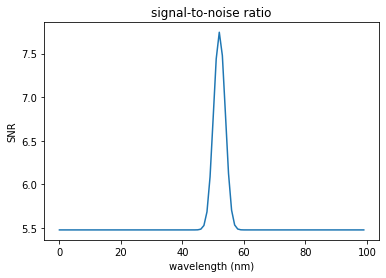

In [5]:
pl.figure()
pl.plot(np.sqrt(spectrum))
pl.title('signal-to-noise ratio')
pl.ylabel('SNR')
pl.xlabel('wavelength (nm)')

But there is a problem: from this diagram we read that the signal/noise is ~8. But the emission-line is barely detectable ... 
**the definition of signal (and noise) depends on what we are interested in !**

- if we were interested in measuring the background, this SNR calculation would be ok far from the center of the emission-line
- if we are interested in detecting an emission-line above the background this calculation is completely meaningless

so, how do we measure the SNR of an emission-line above a given background ? and how can we say that we have detected something ?

Some examples first

#### The better signal is the one with the strongest flux, i.e. the largest fwhm

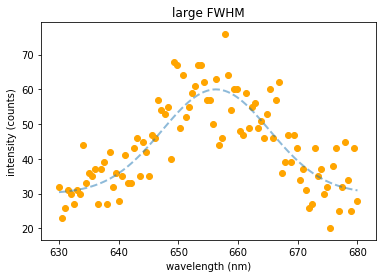

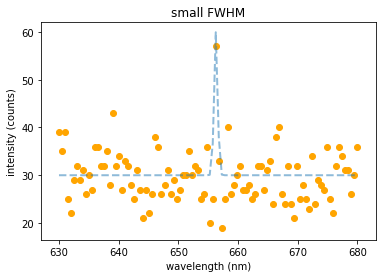

In [6]:
lam, spectrum, noise = simulate_el(30, 30, 30, title='large FWHM')
lam, spectrum, noise = simulate_el(30, 30, 1, title='small FWHM')

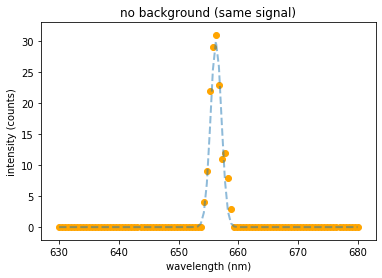

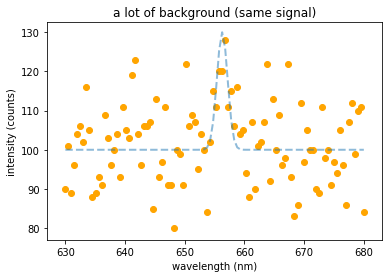

In [7]:
lam, spectrum, noise = simulate_el(0, 30, 3, title='no background (same signal)')
lam, spectrum, noise = simulate_el(100, 30, 3, title='a lot of background (same signal)')

### the CCD equation summarizes it all

Is is here defined for aperure photometry on a CCD (i.e. a 2D signal), but it works perfectly for 1D dispersive spectra

<div>
<img src="../images/ccd_equation.png" width="500"/>
</div>

Howell S. (1989): https://ui.adsabs.harvard.edu/link_gateway/1989PASP..101..616H/doi:10.1086/132477 (important paper)

let's now use it to compute the SNR of our spectrum

In [8]:
def CCD_equation(n_star, n_pix, n_sky, read_noise=0, dark_current=0):
    return np.abs(n_star) / np.sqrt(np.abs(n_star) + n_pix * (n_sky + read_noise**2 + dark_current))

- but what is `n_pix` ? we do not do any aperture photometry here ?

*yes we do!*: the emission-line is a gaussian, i.e. it spreads up to infinity, but most of its flux is concentrated in the central lobe, up to 3 times the FWHM

If we want to do a numerical integration (i.e. no model fitting), we must start somewhere and stop somewehere else. If we emcompass a too large aperture we enhance the noise without having much more signal. If we use a too narrow aperture we may lose an important fraction of the signal... 

In general the best way to do it is to integrate only the channels with the highest SNR and use a model to extrapolate the measured value and account for the missing signal. This is not what we will do as we are only interested here in the que question of SNR. One more time this [Howell S. (1989)](https://ui.adsabs.harvard.edu/link_gateway/1989PASP..101..616H/doi:10.1086/132477) tells you all about it :)

Let's choose `n_pix = 6` i.e. 3 pixels wide around the brightest one, this will be 2 times the FWHM.

We may now compute the true SNR from the known inputs of the simulation

n_sky: 30
n_star: 426.17016853107714
true SNR computed from the input values of the simulation: 17.3095495574528


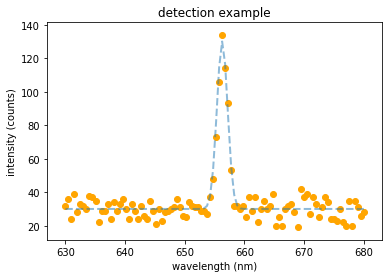

In [9]:
def compute_snr(background, amplitude, fwhm, n_pix=6, title='signal', verbose=True):
    """n_pix should be even"""
    lam, spectrum, noise = simulate_el(background, amplitude, fwhm, title='detection example', plot=verbose)
    center = np.argmin(np.abs(lam - 656.28)) # lambda is known
    if verbose: print('n_sky:', background)
    n_star = np.sum(spectrum[center-n_pix//2:center+n_pix//2+1] - background)
    if verbose: print('n_star:', n_star)
    true_snr = CCD_equation(n_star, n_pix, background)
    if verbose: print('true SNR computed from the input values of the simulation:', true_snr)
    return lam, spectrum, noise, true_snr
lam, spectrum, noise, true_snr = compute_snr(30, 100, 3)

But in real life, we must estimate it, from the data obtained

In [10]:
def estimate_snr(data, center, n_pix=6, verbose=True):
    n_sky = np.median(data[:center-4])
    if verbose: print('n_sky:', n_sky)
    n_star = np.sum(data[center-4:center+4+1] - n_sky)
    if verbose: print('n_star:', n_star)
    n_pix = 9
    snr = CCD_equation(n_star, n_pix, n_sky)
    if verbose: print('estimated SNR: ', snr)
    return snr

center = np.argmin(np.abs(lam - 656.28)) # lambda is known
snr = estimate_snr(spectrum + noise, center)


n_sky: 30.0
n_star: 420.0
estimated SNR:  15.9891267401645


So far so good, we ended with a good estimation of the SNR. But what for low SNR sources ? because the real problem of detection is for faint sources. And that is where all the detection algorithms are compared.

n_sky: 30
n_star: 85.23403370621543
true SNR computed from the input values of the simulation: 5.233574574007006
n_sky: 30.5
n_star: 49.5
estimated SNR:  2.75


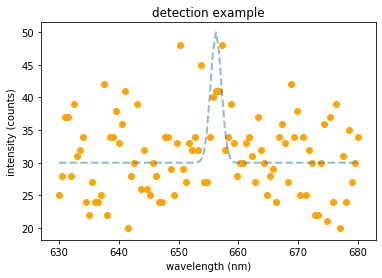

In [15]:
lam, spectrum, noise, true_snr = compute_snr(30, 20, 3)
snr = estimate_snr(spectrum + noise, center)

oups!  hum, not so good, the estimated snr is very far from the true snr.... how do they compare in general ?

Text(0, 0.5, 'estimated SNR - true SNR')

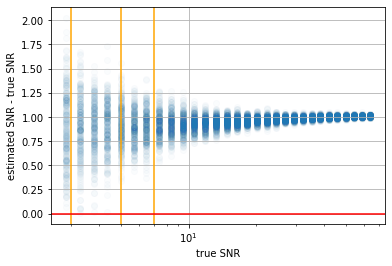

In [69]:
true_snrs = list()
snrs = list()
amplitudes_snr = list()

for iamp in 10**(np.linspace(1, 3, 30)):
    for i in range(300):
        lam, spectrum, noise, true_snr = compute_snr(30, iamp, 3, verbose=False)
        center = np.argmin(np.abs(lam - 656.28)) # lambda is known
        snr = estimate_snr(spectrum + noise, center, verbose=False)
        true_snrs.append(true_snr)
        snrs.append(snr)
        amplitudes_snr.append(iamp)
true_snrs = np.array(true_snrs)
snrs = np.array(snrs)

pl.scatter(true_snrs, snrs / true_snrs, alpha=0.02)
pl.xscale('log')
#pl.xlim((1, 100))
#pl.ylim((0.9, 5.2))
pl.grid()
pl.axvline(x=3, c='orange')
pl.axvline(x=5, c='orange')
pl.axvline(x=7, c='orange')
pl.axhline(y=0, c='red')
pl.xlabel('true SNR')
pl.ylabel('estimated SNR - true SNR')

- We see a dispersion of nearly 50% (=1.5 for a SNR of 3) below a SNR of 10 (if the background where exactly 0 this would tend to be 1)

i.e. **low SNR values are not reliable** ! what is the meaning of a SNR of 3$\pm$1.5 when we want to conclude to a detection ?

Also, this concept is meaningfull in some situations but do not covers well most situations. It works perfectly where it is not needed: strong signal, well-known noise, good models of the instrument, noise and signal... And it does not work at all when one of this hypotheses is not fulfilled (e.g. noise distribution is not well known, the shape of the emission is not a Gaussian etc.). For example, in the CCD equation, a large number of hypotheses are considered:

- background is known, or may be well estimated ... this is nt always the case
- noise follows a Poisson distribution, i.e. it can be estimated from the data itself (true for an unreduced CCD image, but generally wrong)
- instrumental effects are known and are limited to two terms: n_read, n_dark

<div>
<img src="../images/amphib.jpg" width="500"/>
</div>
https://retrosci-fi.tumblr.com/post/151431269239/amphibious-bicycle-retro-futurism

But these hypotheses remain somehow hidden, since they are not clearly described as an instrumental model + a source model + a background model. The CCD equation was useful when computational power was low but you must look for something more robust now. Two statistical frameworks can be used: the frequentist approach or the bayesian approach. In all cases you will have to explicitely model your knowledge of the instrument, the background and the source. And the reliability of your data will rely on the estimation of the uncertainty on the parameters of the whole model of your experience. 

## Classical 'model-explicit' approach on this problem

estimated_parameters: [29.29529103 17.11650496]
estimated_uncertainties: [0.56003116 3.76492292]


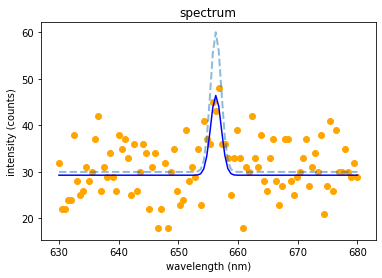

In [13]:
def mymodel(x, h, a):
    # fwhm and wavelength are considered known (explicitely), if they are not, we can add them as fitted parameters
    # but the precision on the other parameters will be reduced
    # in this model, the shape of the source and the background are explicitly given
    return h + gaussian_emission_line(x, a, 656.28, 3)

def fit(lam, data):
    dx_init = lam[np.argmax(data)]
    p_init = [np.median(data), np.max(data)]
    def residual(p, data, x):
        simdata  = mymodel(x, *p)
        # here we see that poisson noise is considered
        # indeed the residual is (data - model) / (uncertainty on the data)
        return (simdata - data) / np.sqrt(data)
    fit = scipy.optimize.least_squares(residual, p_init, args=(data, lam))
    # compute uncetainty from the jacobian... see next workshop tu understand that
    J = fit.jac
    cov = np.linalg.inv(J.T.dot(J))
    perr = np.sqrt(np.diagonal(cov))
    return fit.x, perr

lam, spectrum, noise = simulate_el(30, 30, 3, plot=True)
p, perr = fit(lam, spectrum + noise)
print('estimated_parameters:', p)
print('estimated_uncertainties:', perr)
fitted_spectrum = mymodel(lam, *p)
pl.plot(lam, fitted_spectrum, color='blue')

In [76]:
true_uncertainties = list()
estimated_uncertainties = list()
estimated_uncertainties_std = list()
amplitudes = 10**(np.linspace(1, 3, 10))
for iamp in amplitudes:
    print('computing amplitude', iamp)
    error_bin = list()
    uncertainty_bin = list()
    for i in range(2000):
        lam, spectrum, noise = simulate_el(30, iamp, 3, plot=False)
        #try:
        p, perr = fit(lam, spectrum + noise)
        #except: pass
        #else:
        error_bin.append((p[1] - iamp))
        uncertainty_bin.append(perr[1])
        
    error_bin = np.array(error_bin) # true error on the estimation of the parameter
    uncertainty_bin = np.array(uncertainty_bin) # estimation of the uncertainty on the parameter
    
    good_fits = (error_bin < np.percentile(error_bin, 99.99)) * (error_bin > np.percentile(error_bin, 0.01))
    true_uncertainties.append(np.std(error_bin[good_fits]))
    
    estimated_uncertainties.append(np.mean(uncertainty_bin[good_fits]))
    estimated_uncertainties_std.append(np.std(uncertainty_bin[good_fits]))
    
true_uncertainties = np.array(true_uncertainties)
estimated_uncertainties = np.array(estimated_uncertainties)
estimated_uncertainties_std = np.array(estimated_uncertainties_std)

computing amplitude 10.0
computing amplitude 16.68100537200059
computing amplitude 27.825594022071243
computing amplitude 46.41588833612777
computing amplitude 77.4263682681127
computing amplitude 129.1549665014884
computing amplitude 215.44346900318823
computing amplitude 359.38136638046257
computing amplitude 599.4842503189409
computing amplitude 1000.0


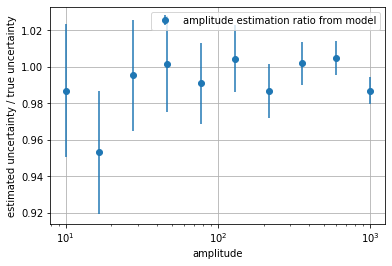

In [80]:
pl.errorbar(amplitudes, estimated_uncertainties / true_uncertainties, yerr=estimated_uncertainties_std / true_uncertainties, 
            ls='none', marker='o', label='amplitude estimation ratio from model')
pl.xscale('log')
pl.grid()
pl.xlabel('amplitude')
pl.ylabel('estimated uncertainty / true uncertainty')
pl.legend()


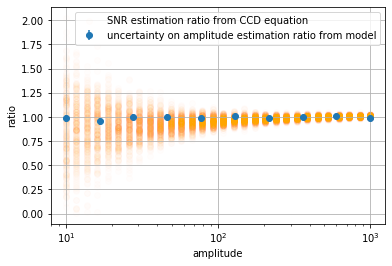

In [79]:
pl.scatter(amplitudes_snr, snrs / true_snrs, alpha=0.01, c='orange', label='SNR estimation ratio from CCD equation')
pl.errorbar(amplitudes, estimated_uncertainties / true_uncertainties, yerr=estimated_uncertainties_std / true_uncertainties, 
            ls='none', marker='o', label='uncertainty on amplitude estimation ratio from model')
pl.xscale('log')
pl.grid()
pl.xlabel('amplitude')
pl.ylabel('ratio')
pl.legend()


## other problems with SNR

- the limit of 3 for detection
  - when we do not know where the signal should be: is 3 a good threshold ?
  - ex in 2D, ex in 3D (exercise on star detection)
  
